In [17]:
# 1. Generate 15 Cities theo 6 số cuối mã số học viên
import numpy as np

def generate_cities(n, seed):
    np.random.seed(seed)
    return np.random.rand(n, 2)

# Ví dụ phát sinh 15 thành phố với mã học viên là 230101074
cities = generate_cities(15, 230101074)

In [18]:
# 2. Tính khoảng cách khi travel qua các thành phố bằng khoảng cách Euclidean
def calculate_distance(cities, path):
    distance = 0
    for i in range(len(path)):
        city1 = cities[path[i]]
        city2 = cities[path[(i + 1) % len(path)]]  # Vòng quay về thành phố đầu tiên
        distance += np.linalg.norm(city1 - city2)  # Khoảng cách Euclidean
    return distance

In [19]:
# 2 phép CrossOver
def order_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(np.random.choice(range(size), 2, replace=False))

    child1 = [-1] * size
    child2 = [-1] * size

    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]

    # Điền phần còn lại dựa trên thứ tự xuất hiện trong parent2 và parent1
    pos = end
    for i in range(size):
        if parent2[(end + i) % size] not in child1:
            child1[pos % size] = parent2[(end + i) % size]
            pos += 1
        if parent1[(end + i) % size] not in child2:
            child2[pos % size] = parent1[(end + i) % size]
            pos += 1

    return child1, child2

def position_based_crossover(parent1, parent2):
    size = len(parent1)

    # Chọn ngẫu nhiên một tập các vị trí từ parent1 để giữ lại
    positions = np.random.choice(range(size), size=size//2, replace=False)
    child1 = [-1] * size
    child2 = [-1] * size

    # Giữ các vị trí được chọn từ parent1
    for pos in positions:
        child1[pos] = parent1[pos]
        child2[pos] = parent2[pos]

    # Điền các giá trị còn thiếu từ parent2 vào child1
    pos_fill = 0
    for gene in parent2:
        if gene not in child1:
            while child1[pos_fill] != -1:
                pos_fill += 1
            child1[pos_fill] = gene

    # Điền các giá trị còn thiếu từ parent1 vào child2
    pos_fill = 0
    for gene in parent1:
        if gene not in child2:
            while child2[pos_fill] != -1:
                pos_fill += 1
            child2[pos_fill] = gene

    return child1, child2

In [20]:
# 2 phép đột biến
def swap_mutation(individual):
    idx1, idx2 = np.random.choice(len(individual), 2, replace=False)
    individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
    return individual

def inverse_mutation(individual):
    start, end = sorted(np.random.choice(len(individual), 2, replace=False))
    individual[start:end] = individual[start:end][::-1]  # Đảo ngược đoạn giữa
    return individual

In [21]:
# Selection
def tournament_selection(population, fitness_values, tournament_size=4):
    selected = []
    for _ in range(len(population)):
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        best_idx = min(tournament_indices, key=lambda i: fitness_values[i])
        selected.append(population[best_idx])
    return selected

In [22]:
# Hàm chính GA POPOP:
def popop_ga(cities, pop_size, max_evaluations, crossover_type, mutation_type):
    # Khởi tạo quần thể
    population = [np.random.permutation(len(cities)) for _ in range(pop_size)]
    evaluations = 0
    best_fitness_list = []

    while evaluations < max_evaluations:
        fitness_values = [calculate_distance(cities, ind) for ind in population]
        evaluations += pop_size

        # Lai ghép
        offspring = []
        for _ in range(pop_size // 2):
            parent1 = tournament_selection(population, fitness_values)[0]
            parent2 = tournament_selection(population, fitness_values)[0]
            if crossover_type == 'OX':
                child1, child2 = order_crossover(parent1, parent2)
            elif crossover_type == 'PBX':
                child1, child2 = position_based_crossover(parent1, parent2)
            else:
                # Thêm crossover khác (ví dụ: ERX) nếu cần
                pass
            offspring.append(child1)
            offspring.append(child2)

        # Đột biến
        for i in range(len(offspring)):
            if mutation_type == 'swap':
                offspring[i] = swap_mutation(offspring[i])
            elif mutation_type == 'inverse':
                offspring[i] = inverse_mutation(offspring[i])

        # Tạo quần thể kết hợp
        combined_population = population + offspring
        combined_fitness_values = [calculate_distance(cities, ind) for ind in combined_population]
        evaluations += pop_size

        # Chọn lọc tournament
        population = tournament_selection(combined_population, combined_fitness_values)
        best_fitness = min(combined_fitness_values)
        best_fitness_list.append(best_fitness)

        if evaluations >= max_evaluations:
            break

    return best_fitness_list


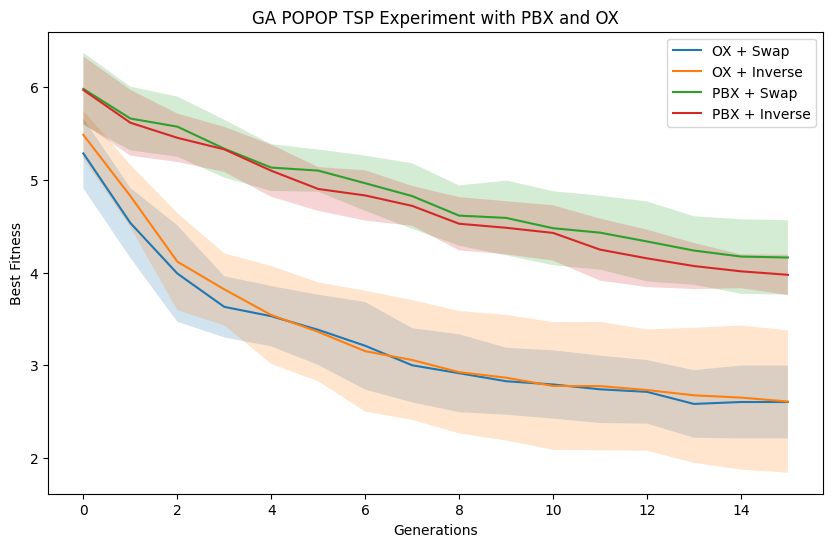

In [23]:
# Chạy thử nghiệm và vẽ đồ thị:
import matplotlib.pyplot as plt

# Chạy thử nghiệm với các phép lai ghép và đột biến
n_trials = 10
pop_size = 64
max_evaluations = 2000

results = {
    'OX + Swap': [],
    'OX + Inverse': [],
    'PBX + Swap': [],
    'PBX + Inverse': [],
}

for _ in range(n_trials):
    results['OX + Swap'].append(popop_ga(cities, pop_size, max_evaluations, 'OX', 'swap'))
    results['OX + Inverse'].append(popop_ga(cities, pop_size, max_evaluations, 'OX', 'inverse'))
    results['PBX + Swap'].append(popop_ga(cities, pop_size, max_evaluations, 'PBX', 'swap'))
    results['PBX + Inverse'].append(popop_ga(cities, pop_size, max_evaluations, 'PBX', 'inverse'))

# Vẽ đồ thị trung bình và độ lệch chuẩn
def plot_results(results):
    plt.figure(figsize=(10, 6))
    for method, data in results.items():
        avg_fitness = np.mean(data, axis=0)
        std_fitness = np.std(data, axis=0)
        plt.plot(avg_fitness, label=method)
        plt.fill_between(range(len(avg_fitness)), avg_fitness - std_fitness, avg_fitness + std_fitness, alpha=0.2)

    plt.title('GA POPOP TSP Experiment with PBX and OX')
    plt.xlabel('Generations')
    plt.ylabel('Best Fitness')
    plt.legend()
    plt.show()

plot_results(results)


# Nhận xét

- Trong bài thực nghiệm trên ta có
    + Hai phép lai crossover:
        - order_crossover
        - position_based_crossover
    + Hai phép đột biến
        - swap_mutation
        - inverse_mutation

Qua thực nghiệm ta thấy:

1. Crossover (Lai ghép)
Order Crossover (OX):
Kết quả cho thấy OX là một phép lai ghép rất hiệu quả cho bài toán TSP. Nó duy trì được thứ tự các thành phố trong chuỗi gen, giúp bảo toàn các chuỗi con có ý nghĩa từ các cha mẹ và giảm thiểu số lượng đột biến cần thiết để tìm ra giải pháp tốt hơn.
Position Based Crossover (PBX):
Kết quả từ PBX không tốt bằng OX, và điều này có thể là do PBX ít giữ được các cấu trúc chuỗi quan trọng khi so sánh với OX. Tuy nhiên, PBX vẫn có xu hướng cải thiện nhưng với tốc độ chậm hơn và kém ổn định hơn.
2. Mutation (Đột biến)
Swap Mutation:
Swap mutation hoạt động tốt, đặc biệt khi kết hợp với OX. Phép đột biến này mang lại sự thay đổi nhỏ trong hành trình và giữ được cấu trúc tổng thể, giúp cải thiện kết quả một cách ổn định.
Inverse Mutation:
Inverse mutation cũng có hiệu quả nhưng không cao bằng Swap mutation. Nó có xu hướng thay đổi một đoạn lớn của hành trình, điều này có thể hữu ích trong các giai đoạn khám phá ban đầu nhưng ít hiệu quả hơn trong việc tinh chỉnh hành trình ở các giai đoạn sau.
3. Hiệu quả của các phép kết hợp
Kết hợp OX + Swap rõ ràng là phương án tốt nhất. Nó không chỉ giảm chi phí hành trình nhanh hơn mà còn có độ lệch chuẩn nhỏ hơn, chỉ ra rằng phương pháp này không chỉ hiệu quả mà còn ổn định trong nhiều lần thực nghiệm.
Kết hợp PBX + Inverse và PBX + Swap cho thấy sự kém hiệu quả hơn so với OX. Tuy nhiên, điều này cho thấy việc thử nghiệm thêm các phương pháp crossover hoặc tối ưu hóa thêm cho PBX có thể cần thiết để đạt được hiệu suất cao hơn.
4. Đề xuất phương pháp tối ưu
Phép lai ghép OX kết hợp với Swap mutation là phương pháp tối ưu nhất dựa trên kết quả của bạn. Phép lai ghép OX giữ lại thông tin quan trọng từ cha mẹ, trong khi Swap mutation giúp tinh chỉnh dần dần để tối ưu hóa hành trình.